In [1]:
import cv2
import numpy
import glob
import os
import numpy
import collections

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm     as cm

In [3]:
import skimage.measure
import skimage.color

In [4]:
files = sorted(glob.glob('images/captcha[1-6].png'))

### Testa threshold

In [5]:
sufixes = {
    cv2.THRESH_BINARY: 'binary',
    cv2.THRESH_BINARY_INV: 'binary_inv',
    cv2.THRESH_TRUNC: 'trunc',
    cv2.THRESH_TOZERO: 'tozero',
    cv2.THRESH_TOZERO_INV: 'tozero_inv'
}

# le a imagem
image = cv2.imread('images/captcha1.png')

# transforma ela de colorida (RGB) para tons de cinza
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# aplica o thresholding
for thresh in [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]:
    # o segundo parametro, 127, Ã© ignorado
    (limiar, bw) = cv2.threshold(gray, 127, 255, thresh | cv2.THRESH_OTSU)
    cv2.imwrite('bw_captcha_' + sufixes[thresh] + '.png', bw)
    print limiar

136.0
136.0
136.0
136.0
136.0


### Histograma de tons de cinza

In [6]:
img  = cv2.imread('images/captcha6.png')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hist, bins = numpy.histogram(gray, gray.max() - gray.min() + 1)

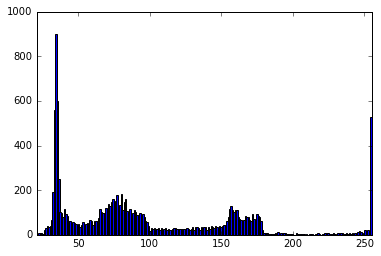

In [7]:
plt.bar(bins[:-1], hist, width = 1)
plt.xlim(min(bins), max(bins))
plt.figaspect(0.5)
plt.show()

### Binariza com OTSU

In [8]:
def binarize(file):
    image = cv2.imread(file)

    # transforma ela de colorida (RGB) para tons de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    (_, bw) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return bw

In [9]:
for file in files:
    base = os.path.basename(file)
    
    bw   = binarize(file)
    cv2.imwrite(base.replace('captcha', 'bw_captcha'), bw)

### Recorta o que nao tem importancia

In [10]:
for file in files:
    base = os.path.basename(file)
    
    bw   = binarize(file)
    bw   = bw[:, 30:180]
    cv2.imwrite(base.replace('captcha', 'bw_captcha').replace('.png', '_crop.png'), bw)

### Recorta antes de passar a binarizacao

In [11]:
def cut_and_binarize(file):
    image = cv2.imread(file)

    # transforma ela de colorida (RGB) para tons de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gray[:, 30:180]

    (_, bw) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return bw

In [12]:
for file in files:
    base = os.path.basename(file)
    
    bw   = cut_and_binarize(file)
    cv2.imwrite(base.replace('captcha', 'bw_captcha').replace('.png', '_crop2.png'), bw)

### Segmentacao - Labels

In [13]:
def labelize(file):
    bw = cut_and_binarize(file)
    
    (labels, total) = skimage.measure.label(bw, background=0, return_num=True, connectivity=2)
    images = [numpy.uint8(labels==i) * 255 for i in range(total) if numpy.uint8(labels==i).sum() > 25]
    
    img = skimage.color.label2rgb(labels, bg_color=[1, 1, 1])
    
    for label in images:
        (countours, _) = cv2.findContours(label.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        (x,y,w,h)  = cv2.boundingRect(countours[0])
    
        cv2.rectangle(img, (x, y), (x+w, y+h), (1, 0, 0), 1)
        
    img2 = img * 255.0
    return img2.astype(numpy.uint8)

In [14]:
for file in files:
    base = os.path.basename(file)
    
    bw   = labelize(file)
    cv2.imwrite(base.replace('captcha', 'bw_captcha').replace('.png', '_label.png'), bw)

### Limpeza

In [15]:
def cleanup(file):
    bw = cut_and_binarize(file)
    
    (labels, total) = skimage.measure.label(bw, background=0, return_num=True, connectivity=2)
    images = [numpy.uint8(labels==i) * 255 for i in range(total) if numpy.uint8(labels==i).sum() > 25]
    
    cleaned = numpy.zeros(bw.shape, numpy.uint8)
    
    # junta todos os labels reconhecidos
    for label in images:
        cleaned = cleaned + label
        
    cleaned = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2RGB)
    
    # pinta o retangulo neles
    for label in images:
        (countours, _) = cv2.findContours(label.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        (x,y,w,h)      = cv2.boundingRect(countours[0])
    
        cv2.rectangle(cleaned, (x, y), (x+w, y+h), (255, 0, 0), 1)
    
    return cleaned

In [16]:
for file in files:
    base = os.path.basename(file)
    
    bw   = cleanup(file)
    cv2.imwrite(base.replace('captcha', 'bw_captcha').replace('.png', '_cleaned.png'), bw)

### Recorte das mil imagens

In [17]:
def simple_cleanup(file):
    bw = cut_and_binarize(file)
    
    (labels, total) = skimage.measure.label(bw, background=0, return_num=True, connectivity=2)
    images = [numpy.uint8(labels==i) * 255 for i in range(total) if numpy.uint8(labels==i).sum() > 25]
    
    cropped = []
    dimensions   = []
    
    for label in images:
        (countours, _) = cv2.findContours(label.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        (x,y,w,h)      = cv2.boundingRect(countours[0])
    
        surface = label.sum() / 255
        area = w * h
        
        label = label[y:y+h, x:x+w]
        
        dimensions.append((x, y, w, h, area, surface, label))
        
    return dimensions

In [18]:
i = 1

stats = []

for file in glob.glob('images/*.png'):
    _stats = simple_cleanup(file)
    stats.extend(_stats)
    
    for crop in _stats:
        cv2.imwrite('crop/%04d.png' % (i), crop[6])
        i = i + 1

## Reconhecimento 

In [19]:
def histogram(points):
    hist, bins = numpy.histogram(points, points.max() - points.min() + 1)
    
    plt.bar(bins[:-1], hist, width = 1)
    plt.xlim(min(bins), max(bins))
    plt.show()

### Estatisticas

In [20]:
# arrays com todos os x iniciais
xs = numpy.array([s[0] for s in stats])

# arrays com todos os y iniciais
ys = numpy.array([s[1] for s in stats])

# arrays com todas as larguras
widths = numpy.array([s[2] for s in stats])

# arrays com todas as alturas
heights = numpy.array([s[3] for s in stats])

# array com as areas dos bounding boxes
areas = numpy.array([s[4] for s in stats])

# array com as quantidade de pixels de cada letra
surfaces = numpy.array([s[5] for s in stats])

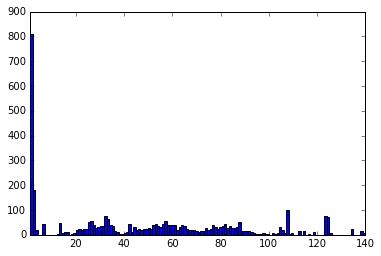

(44.0, 46.729960053262317, 38.922498635087706, 1, 140, 3755)

In [21]:
histogram(xs)
numpy.median(xs), xs.mean(), xs.std(), xs.min(), xs.max(), xs.size

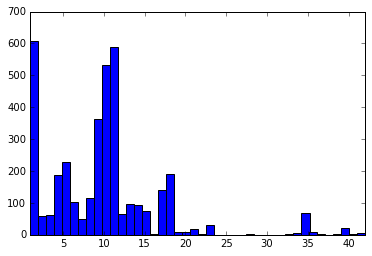

(10.0, 9.5744340878828229, 7.0724601511212164, 1, 42, 3755)

In [22]:
histogram(ys)
numpy.median(ys), ys.mean(), ys.std(), ys.min(), ys.max(), ys.size

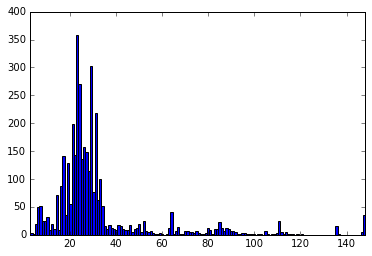

(25.0, 32.020239680426101, 23.786928466169616, 3, 148, 3755)

In [23]:
histogram(widths)
numpy.median(widths), widths.mean(), widths.std(), widths.min(), widths.max(), widths.size

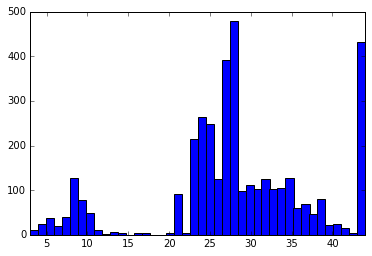

(28.0, 28.251398135818906, 9.6044912951472057, 3, 44, 3755)

In [24]:
histogram(heights)
numpy.median(heights), heights.mean(),  heights.std(), heights.min(), heights.max(), heights.size

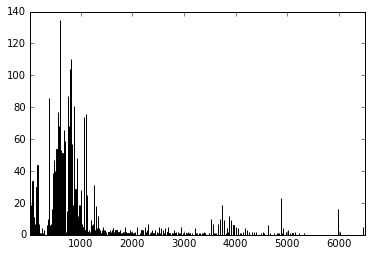

(702.0, 1041.2902796271637, 1118.355745872612, 21, 6512, 3755)

In [25]:
histogram(areas)
numpy.median(areas), areas.mean(), areas.std(), areas.min(), areas.max(), areas.size

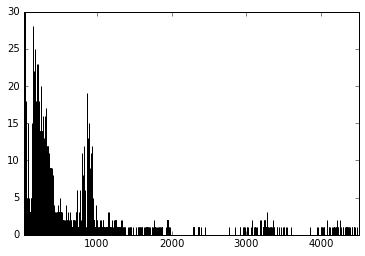

(258.0, 470.16884154460718, 710.06190517138862, 26, 4505, 3755)

In [26]:
histogram(surfaces)
numpy.median(surfaces), surfaces.mean(),  surfaces.std(), surfaces.min(), surfaces.max(), surfaces.size

### Encontrando outliers

In [27]:
def compute_outliers(data):
    q1 = numpy.percentile(data, 25)
    q2 = numpy.percentile(data, 50)
    q3 = numpy.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = max(data.min(), q1 - (1.5 * iqr))
    upper_bound = min(data.max(), q3 + (1.5 * iqr))
    
    return (q1, q2, q3, iqr, lower_bound, upper_bound)

In [28]:
compute_outliers(xs)

(2.0, 44.0, 77.0, 75.0, 1, 140)

In [29]:
compute_outliers(ys)

(5.0, 10.0, 11.0, 6.0, 1, 20.0)

In [30]:
compute_outliers(widths)

(21.0, 25.0, 31.0, 10.0, 6.0, 46.0)

In [31]:
compute_outliers(heights)

(24.0, 28.0, 34.0, 10.0, 9.0, 44)

In [32]:
compute_outliers(areas)

(560.0, 702.0, 1050.0, 490.0, 21, 1785.0)

In [33]:
compute_outliers(surfaces)

(170.0, 258.0, 392.5, 222.5, 26, 726.25)

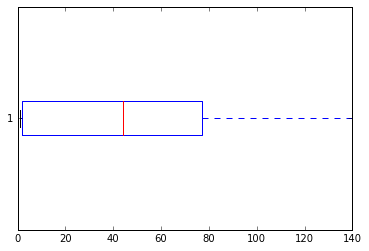

In [34]:
_ = plt.boxplot(xs, vert=0)

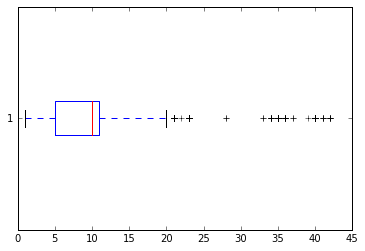

In [35]:
_ = plt.boxplot(ys, vert=0)

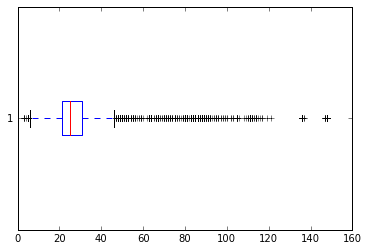

In [36]:
_ = plt.boxplot(widths, vert=0)

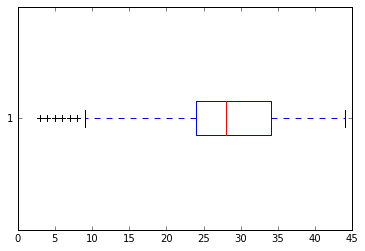

In [37]:
_ = plt.boxplot(heights, vert=0)

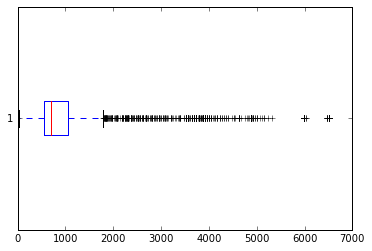

In [38]:
_ = plt.boxplot(areas, vert=0)

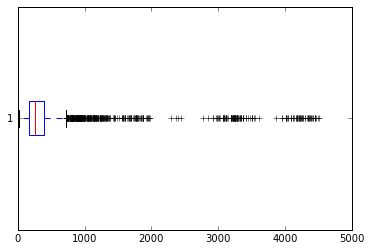

In [39]:
_ = plt.boxplot(surfaces, vert=0)

### Removendo outliers

In [40]:
filtered = stats
filtered = [s for s in filtered if s[1] < 20 and s[2] > 6 and s[2] < 46 and s[3] > 9 and s[4] < 1785 and s[5] < 727]

# arrays com todos os x iniciais
xs = numpy.array([s[0] for s in filtered])

# arrays com todos os y iniciais
ys = numpy.array([s[1] for s in filtered])

# arrays com todas as larguras
widths = numpy.array([s[2] for s in filtered])

# arrays com todas as alturas
heights = numpy.array([s[3] for s in filtered])

# array com as areas dos bounding boxes
areas = numpy.array([s[4] for s in filtered])

# array com as quantidade de pixels de cada letra
surfaces = numpy.array([s[5] for s in filtered])

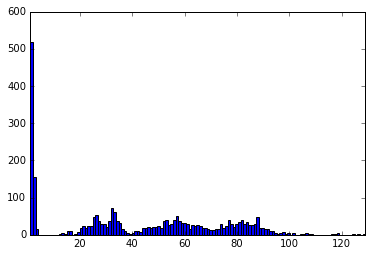

(43.0, 42.233655274888555, 31.428803658707228, 1, 129, 2692)

In [41]:
histogram(xs)
numpy.median(xs), xs.mean(), xs.std(), xs.min(), xs.max(), xs.size

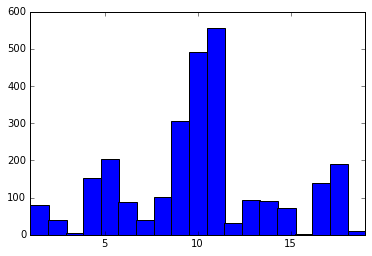

(10.0, 10.080980683506686, 4.1753160147235162, 1, 19, 2692)

In [42]:
histogram(ys)
numpy.median(ys), ys.mean(), ys.std(), ys.min(), ys.max(), ys.size

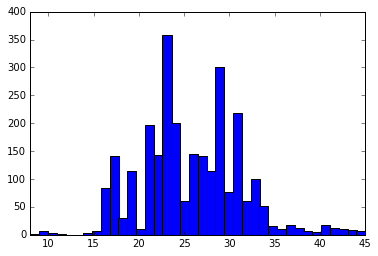

(25.0, 25.680163447251115, 5.6914086581572061, 8, 45, 2692)

In [43]:
histogram(widths)
numpy.median(widths), widths.mean(), widths.std(), widths.min(), widths.max(), widths.size

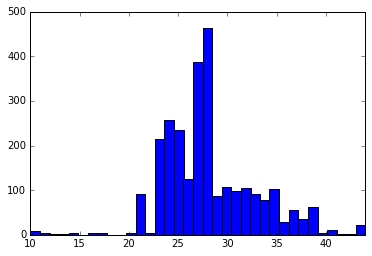

(28.0, 28.177934621099553, 4.7951254237304974, 10, 44, 2692)

In [44]:
histogram(heights)
numpy.median(heights), heights.mean(),  heights.std(), heights.min(), heights.max(), heights.size

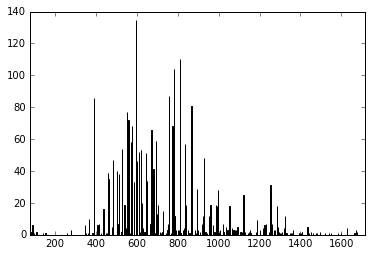

(675.0, 732.09732540861808, 236.9660593034192, 80, 1716, 2692)

In [45]:
histogram(areas)
numpy.median(areas), areas.mean(), areas.std(), areas.min(), areas.max(), areas.size

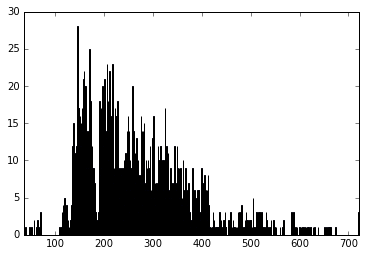

(243.0, 261.81872213967313, 102.91941974200624, 36, 721, 2692)

In [46]:
histogram(surfaces)
numpy.median(surfaces), surfaces.mean(),  surfaces.std(), surfaces.min(), surfaces.max(), surfaces.size

### Normalizacao dos Recortes

In [47]:
def normalize(image):
    (h, w) = image.shape
    fx = w / 64.0
    fy = h / 64.0
    
    f = max(fx, fy)
  
    w_ = int(w / f)
    h_ = int(h / f)
    
    resized = cv2.resize(image, (w_, h_))
    
    box = numpy.zeros((64, 64), dtype=numpy.uint8)
    
    x0  = (64 - w_) / 2
    y0  = (64 - h_) / 2
        
    box[y0:y0 + h_, x0:x0 + w_] = resized
    
    return box

In [48]:
normalized = [(normalize(s[6]), s[6]) for s in filtered]

In [49]:
normalized = sorted(normalized, key=lambda x: x[0].sum())

### Agrupamento

In [50]:
def mse(image, image2):
    error = numpy.sum(((image.astype(numpy.float) - image2.astype(numpy.float))/255.0) ** 2)
    error /= float(image.shape[0] * image.shape[1])
    
    return error

In [51]:
def group(limiar, normalized):
    groups = collections.defaultdict(list)
    computed = set()

    for (i, images) in enumerate(normalized):
        if i in computed:
            continue

        found = False

        for (j, images2) in enumerate(normalized):

            if i >= j or j in computed:
                continue

            dist = mse(images[0], images2[0])

            if dist < limiar:
                groups[i].append(j)
                found = True
                computed.add(j)

        if not found:
            groups[i].append(i)
            
    return groups

In [52]:
groups = group(0.05, normalized)

In [53]:
groups6 = group(0.06, normalized)

In [54]:
groups7 = group(0.07, normalized)

In [55]:
groups8 = group(0.08, normalized)

In [56]:
groups9 = group(0.09, normalized)

In [57]:
groups10 = group(0.1, normalized)

In [58]:
groups15 = group(0.15, normalized)

### Salva os grupos

In [59]:
def save(directory, groups, normalized):
    for i in groups.keys():
        if len(groups[i]) < 3:
            continue

        subdirectory = os.path.join(directory, '%04d' % (i))
        
        if not os.path.isdir(subdirectory):
            os.makedirs(subdirectory)

        file = os.path.join(subdirectory, '%04d.png' % (i))
        cv2.imwrite(file, normalized[i][0])

        
        file = os.path.join(subdirectory, '%04d_original.png' % (i))
        cv2.imwrite(file, normalized[i][1])
        
        for j in groups[i]:
            dist = mse(normalized[i][0], normalized[j][0])
            
            file = os.path.join(subdirectory, '%04d_%0.3f.png' % (j, dist))
            cv2.imwrite(file, normalized[j][0])
            
            file = os.path.join(subdirectory, '%04d_%0.3f_original.png' % (j, dist))
            cv2.imwrite(file, normalized[j][1])

In [60]:
save('groups10', groups10, normalized)

### Carrega os templates 

In [61]:
def load_templates(directory):
    pattern = os.path.join(directory, '*', '*_original.png')
    images = glob.glob(pattern)
    
    templates = collections.defaultdict(list)
    
    for image in images:
        if '0.' in image:
            continue
            
        letter = os.path.basename(os.path.dirname(image))
        
        # carrega a imagem, como o opencv carrega PNG como
        # RGB, tem q transformar para tons de cinza
        template = cv2.imread(image)
        template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        
        templates[letter].append(template)
        
    return templates

In [62]:
templates = load_templates('templates/')

### Quebra o captcha

In [63]:
def search_for_letter(image, letter, templates, method):
    best = 2 ** 32
    
    if method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        best = 0.0
        
    pos  = None

    for template in templates:
        match = cv2.matchTemplate(image, template, method)
        minVal,maxVal,minLoc,maxLoc = cv2.minMaxLoc(match)

        if method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                
            if best < maxVal:
                pos = {
                    'error': maxVal,
                    'location': maxLoc,
                    'letter': letter
                }
                best = maxVal
        else:
            
            if best > minVal:
                pos = {
                    'error': minVal,
                    'location': minLoc,
                    'letter': letter
                }
                
                best = minVal

    return pos
    
def search(file, templates, method):
    matches = []

    image = cut_and_binarize(file)

    for letter in templates:
        pos = search_for_letter(image, letter, templates[letter], method)
        
        if pos is not None:
            matches.append(pos)

    reverse = False
    
    if method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        reverse = True
        
    matches = sorted(matches, key=lambda x:x['error'],reverse=reverse)
    return sorted(matches[:4], key=lambda x:x['location'][0])

### Validacao do trabalho

In [64]:
def validation(directory, templates, method):
    captchas = glob.glob(directory + '/*.png')
    
    corrects = 0
    found    = 0
    
    for file in captchas:
        # tenta quebrar o captcha
        matches = search(file, templates, method)
        letters = [match['letter'] for match in matches]
        
        # testa se o captcha casa com o nome do arquivo
        filename = os.path.basename(file)
        captcha  = filename.replace('.png', '')
        captcha  = captcha.upper()

        correct = 0
        
        for letter in letters:
            if letter in captcha:
                correct += 1

        if correct == 4:
            found += 1
            
        corrects += correct
        
    print "Letters:", corrects, "from", (4 * len(captchas)), "(", corrects / (0.04 * len(captchas)), "%)"
    print "Captchas:", found, "from", len(captchas), "(", found / (0.01 * len(captchas)), "%)"

In [65]:
for method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED]:
    print method
    validation('teste/', templates, method)

0
Letters: 350 from 400 ( 87.5 %)
Captchas: 64 from 100 ( 64.0 %)
1
Letters: 378 from 400 ( 94.5 %)
Captchas: 81 from 100 ( 81.0 %)
2
Letters: 140 from 400 ( 35.0 %)
Captchas: 1 from 100 ( 1.0 %)
3
Letters: 381 from 400 ( 95.25 %)
Captchas: 82 from 100 ( 82.0 %)
4
Letters: 324 from 400 ( 81.0 %)
Captchas: 39 from 100 ( 39.0 %)
5
Letters: 384 from 400 ( 96.0 %)
Captchas: 84 from 100 ( 84.0 %)
